### This notebook was used to convert the original PhaseNet weights to SeisBench and ensure binary compatibility. It is not intended for further use, but only serves as a reference

**Last run on 05/01/2023** - note that this notebook will not be kept up to date with changes made to Phasenet or SeisBench.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
PROJECT_ROOT = "/home/muchmej/code/PhaseNet/"

import sys

sys.path.append(PROJECT_ROOT)

In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import obspy
import torch
import seisbench.models as sbm

2023-01-05 09:21:39.093858: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
from phasenet.model import UNet

In [5]:
model = UNet(mode="pred")
sess_config = tf.compat.v1.ConfigProto()
sess_config.gpu_options.allow_growth = True

Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Colocations handled automatically by placer.


In [6]:
sess = tf.compat.v1.Session(config=sess_config)
saver = tf.compat.v1.train.Saver(tf.compat.v1.global_variables())
init = tf.compat.v1.global_variables_initializer()
sess.run(init)
latest_check_point = tf.train.latest_checkpoint(f"{PROJECT_ROOT}/model/190703-214543")
print(f"restoring model {latest_check_point}")
saver.restore(sess, latest_check_point)

2023-01-05 09:21:41.885822: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-05 09:21:41.886417: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2023-01-05 09:21:41.946061: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled


restoring model /home/muchmej/code/PhaseNet//model/190703-214543/model_95.ckpt
INFO:tensorflow:Restoring parameters from /home/muchmej/code/PhaseNet//model/190703-214543/model_95.ckpt


INFO:tensorflow:Restoring parameters from /home/muchmej/code/PhaseNet//model/190703-214543/model_95.ckpt


In [7]:
def predict(vec, aux=False):
    vec = vec.copy()
    vec -= np.mean(vec)
    vec /= np.std(vec)

    feed = {model.X: vec, model.drop_rate: 0, model.is_training: False}
    if aux:
        return sess.run(model.aux, feed_dict=feed)
    else:
        return sess.run(model.preds, feed_dict=feed)

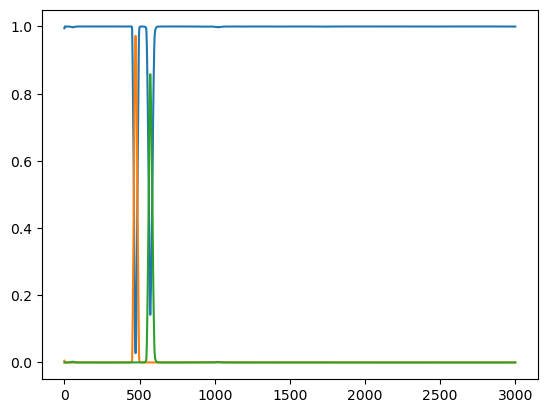

In [8]:
stream = obspy.read()

vec = np.zeros((1, 3001, 1, 3))
vec[0, :-1, 0, 2] = stream[0].data
vec[0, :-1, 0, 1] = stream[1].data
vec[0, :-1, 0, 0] = stream[2].data

preds = predict(vec)

plt.plot(preds[0, :, 0, :])

## Copy weights

In [9]:
pn_vars_names = tf.train.list_variables(PROJECT_ROOT + "model/190703-214543")
pn_vars_names = [
    n for n in pn_vars_names if "Adam" not in n[0]
]  # Remove Adam optimizer state for each layer (for now)
pn_vars_names = [
    n for n in pn_vars_names if len(n[1]) > 0
]  # Remove global variables that are empty lists

pn_vars_names

[('DownConv_0/down_bn1_1/beta', [8]),
 ('DownConv_0/down_bn1_1/gamma', [8]),
 ('DownConv_0/down_bn1_1/moving_mean', [8]),
 ('DownConv_0/down_bn1_1/moving_variance', [8]),
 ('DownConv_0/down_bn3_1/beta', [8]),
 ('DownConv_0/down_bn3_1/gamma', [8]),
 ('DownConv_0/down_bn3_1/moving_mean', [8]),
 ('DownConv_0/down_bn3_1/moving_variance', [8]),
 ('DownConv_0/down_conv1_1/kernel', [7, 1, 8, 8]),
 ('DownConv_0/down_conv3_1/kernel', [7, 1, 8, 8]),
 ('DownConv_1/down_bn1_2/beta', [16]),
 ('DownConv_1/down_bn1_2/gamma', [16]),
 ('DownConv_1/down_bn1_2/moving_mean', [16]),
 ('DownConv_1/down_bn1_2/moving_variance', [16]),
 ('DownConv_1/down_bn3_2/beta', [16]),
 ('DownConv_1/down_bn3_2/gamma', [16]),
 ('DownConv_1/down_bn3_2/moving_mean', [16]),
 ('DownConv_1/down_bn3_2/moving_variance', [16]),
 ('DownConv_1/down_conv1_2/kernel', [7, 1, 8, 16]),
 ('DownConv_1/down_conv3_2/kernel', [7, 1, 16, 16]),
 ('DownConv_2/down_bn1_3/beta', [32]),
 ('DownConv_2/down_bn1_3/gamma', [32]),
 ('DownConv_2/down_bn1

In [10]:
def load_variable(var):
    return tf.train.load_variable(PROJECT_ROOT + "model/190703-214543", var)

In [11]:
sb_model = sbm.PhaseNet(component_order="ENZ")

In [12]:
for k, v in sb_model.state_dict().items():
    print(k, v.shape)

inc.weight torch.Size([8, 3, 7])
inc.bias torch.Size([8])
in_bn.weight torch.Size([8])
in_bn.bias torch.Size([8])
in_bn.running_mean torch.Size([8])
in_bn.running_var torch.Size([8])
in_bn.num_batches_tracked torch.Size([])
down_branch.0.0.weight torch.Size([8, 8, 7])
down_branch.0.1.weight torch.Size([8])
down_branch.0.1.bias torch.Size([8])
down_branch.0.1.running_mean torch.Size([8])
down_branch.0.1.running_var torch.Size([8])
down_branch.0.1.num_batches_tracked torch.Size([])
down_branch.0.2.weight torch.Size([8, 8, 7])
down_branch.0.3.weight torch.Size([8])
down_branch.0.3.bias torch.Size([8])
down_branch.0.3.running_mean torch.Size([8])
down_branch.0.3.running_var torch.Size([8])
down_branch.0.3.num_batches_tracked torch.Size([])
down_branch.1.0.weight torch.Size([16, 8, 7])
down_branch.1.1.weight torch.Size([16])
down_branch.1.1.bias torch.Size([16])
down_branch.1.1.running_mean torch.Size([16])
down_branch.1.1.running_var torch.Size([16])
down_branch.1.1.num_batches_tracked tor

In [13]:
def copy_batch_norm(source_name, target_name, target_dict):
    norm_dict = {
        "weight": "gamma",
        "bias": "beta",
        "running_mean": "moving_mean",
        "running_var": "moving_variance",
    }

    for pt_name, tf_name in norm_dict.items():
        target_dict[f"{target_name}.{pt_name}"] = load_variable(
            f"{source_name}/{tf_name}"
        )

    target_dict[f"{target_name}.num_batches_tracked"] = np.array(0)

In [14]:
def copy_conv(source_name, target_name, target_dict, bias=True):
    target_dict[f"{target_name}.weight"] = load_variable(f"{source_name}/kernel")[
        :, 0, :, :
    ].T

    if bias:
        target_dict[f"{target_name}.bias"] = load_variable(f"{source_name}/bias")

In [15]:
def copy_conv_trans(source_name, target_name, target_dict, bias=True):
    data = load_variable(f"{source_name}/kernel")[:, 0, :, :]
    target_dict[f"{target_name}.weight"] = np.transpose(data, (2, 1, 0))

    if bias:
        target_dict[f"{target_name}.bias"] = load_variable(f"{source_name}/bias")

In [16]:
new_state_dict = {}

In [17]:
# Input - Original component order ENZ
copy_batch_norm("Input/input_bn", "in_bn", new_state_dict)
copy_conv("Input/input_conv", "inc", new_state_dict)

In [18]:
# Down branch
for i in range(5):
    copy_conv(
        f"DownConv_{i}/down_conv1_{i + 1}",
        f"down_branch.{i}.0",
        new_state_dict,
        bias=False,
    )
    copy_batch_norm(
        f"DownConv_{i}/down_bn1_{i + 1}", f"down_branch.{i}.1", new_state_dict
    )
    if i != 4:
        copy_conv(
            f"DownConv_{i}/down_conv3_{i + 1}",
            f"down_branch.{i}.2",
            new_state_dict,
            bias=False,
        )
        copy_batch_norm(
            f"DownConv_{i}/down_bn3_{i + 1}", f"down_branch.{i}.3", new_state_dict
        )

In [19]:
# Up branch
for i in range(4):
    source_i = 3 - i
    copy_conv_trans(
        f"UpConv_{source_i}/up_conv0_{source_i + 1}",
        f"up_branch.{i}.0",
        new_state_dict,
        bias=False,
    )
    copy_batch_norm(
        f"UpConv_{source_i}/up_bn0_{source_i + 1}", f"up_branch.{i}.1", new_state_dict
    )
    copy_conv(
        f"UpConv_{source_i}/up_conv1_{source_i + 1}",
        f"up_branch.{i}.2",
        new_state_dict,
        bias=False,
    )
    copy_batch_norm(
        f"UpConv_{source_i}/up_bn1_{source_i + 1}", f"up_branch.{i}.3", new_state_dict
    )

In [20]:
# Output
copy_conv("Output/output_conv", "out", new_state_dict)

In [21]:
len(pn_vars_names)

93

In [22]:
len(new_state_dict)

111

In [23]:
state_dict = sb_model.state_dict()
for key in state_dict.keys():
    if key not in new_state_dict:
        print(key)
        continue

    if state_dict[key].shape != new_state_dict[key].shape:
        print(key)

In [24]:
for key, val in new_state_dict.items():
    new_state_dict[key] = torch.tensor(val)

sb_model.load_state_dict(new_state_dict)

<All keys matched successfully>

## Compare models

In [25]:
vec = vec.copy()
vec -= np.mean(vec)
vec /= np.std(vec)

vec_pt = torch.tensor(vec[:, :, 0], dtype=torch.float32).permute(0, 2, 1)

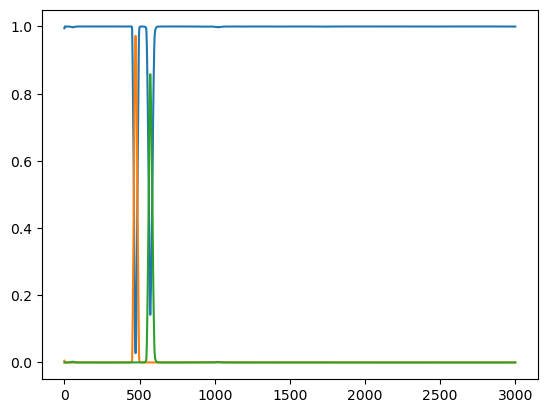

In [26]:
sb_model.eval()

with torch.no_grad():
    pred = sb_model(vec_pt)
    pred = pred.numpy()

aux = pred
plt.plot(aux[0].T);

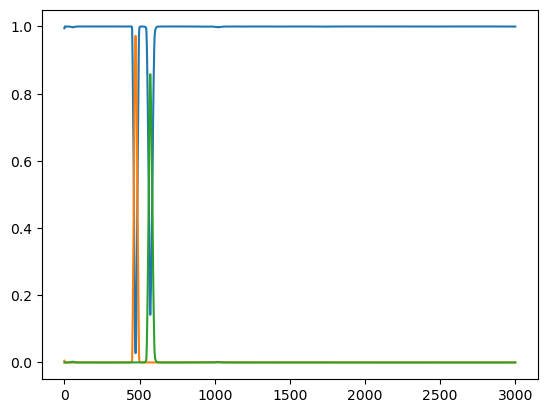

In [27]:
feed = {model.X: vec, model.drop_rate: 0, model.is_training: False}
aux_tf = sess.run(model.preds, feed_dict=feed)

plt.plot(aux_tf[0, :, 0, :]);

2.9802322e-07


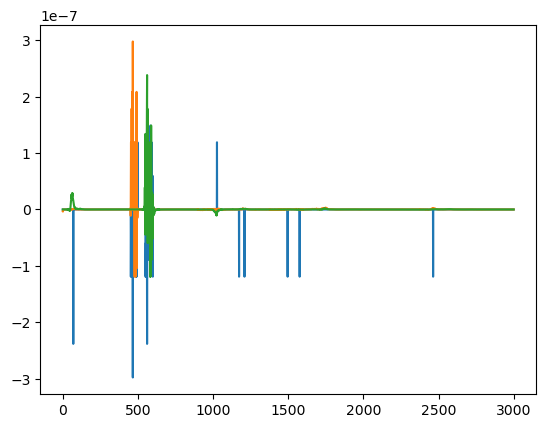

In [28]:
diff = aux[0].T - aux_tf[0, :, 0, :]

plt.plot(diff)
print(np.max(np.abs(diff)))

In [29]:
# sb_model.save("/home/muchmej/.seisbench/models/phasenet/original", weights_docstring="Original PhaseNet model from Zhu et al. (2018). Originally published under MIT License. Original available at https://github.com/AI4EPS/PhaseNet/tree/master/model/190703-214543 . \n\nConverted to SeisBench by Jannes Münchmeyer (munchmej@univ-grenoble-alpes.fr) with help from Sacha Lapins, Yiyuan Zhong, and Jun Zhu")